## Lab 3. Detección de Malware

### Miembros
* Fernanda Esquivel - 21542
* Andrés Montoya - 21552

### Link al repositorio
El repositorio puede ser visualizado [acá](https://github.com/FerEsq/SDS-Lab-04)

# Creación del dataset

In [2]:
import os
import pandas as pd
import numpy as np
import pefile
import hashlib
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from datetime import datetime
warnings.filterwarnings('ignore')

In [3]:
# 1. Creación del dataset mediante análisis estático (enfocado)
def getFileHash(file_path):
    """Calcular el hash MD5 de un archivo."""
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

In [ ]:
def getPEFeatures(file_path):
    """Extraer características estáticas clave de un archivo PE."""
    features = {}
    
    # Metadatos básicos del archivo
    features['file_name'] = os.path.basename(file_path)
    features['file_size'] = os.path.getsize(file_path)
    features['md5'] = getFileHash(file_path)
    
    try:
        pe = pefile.PE(file_path)
        
        #Detección si el ejecutable está empaquetado
        #(Basado en características comunes de empaquetadores)
        is_packed = False
        packed_sections = ['UPX', '.aspack', '.packed', '.MPRESS', '.npack']
        
        # Verificar nombres de secciones sospechosas
        if hasattr(pe, 'sections'):
            for section in pe.sections:
                name = section.Name.decode('utf-8', 'ignore').strip('\x00')
                if any(packer in name for packer in packed_sections):
                    is_packed = True
                    break
        
        #Verificar alta entropía (común en binarios empaquetados)
        high_entropy_sections = 0
        for section in pe.sections:
            #Calcular entropía de la sección
            entropy = 0
            if len(section.get_data()) > 0:
                byte_counts = {}
                for byte in section.get_data():
                    if isinstance(byte, int):  # Para Python 3
                        byte_counts[byte] = byte_counts.get(byte, 0) + 1
                    else:  # Para Python 2
                        byte_counts[ord(byte)] = byte_counts.get(ord(byte), 0) + 1
                
                for count in byte_counts.values():
                    probability = float(count) / len(section.get_data())
                    entropy -= probability * np.log2(probability)
                    
                if entropy > 7.0:  # Umbral de alta entropía
                    high_entropy_sections += 1
        
        if high_entropy_sections >= 2:
            is_packed = True
            
        #Si hay pocos imports es sospechoso de empaquetamiento
        few_imports = False
        if hasattr(pe, 'DIRECTORY_ENTRY_IMPORT'):
            total_imports = sum(len(entry.imports) for entry in pe.DIRECTORY_ENTRY_IMPORT)
            if total_imports < 10:  # Umbral arbitrario para pocos imports
                few_imports = True
                
        if few_imports:
            is_packed = True
            
        features['is_packed'] = 1 if is_packed else 0
        
        #Secciones
        section_names = []
        section_entropies = []
        
        if hasattr(pe, 'sections'):
            for section in pe.sections:
                name = section.Name.decode('utf-8', 'ignore').strip('\x00')
                section_names.append(name)
                
                #Calcular entropía de la sección
                entropy = 0
                if len(section.get_data()) > 0:
                    byte_counts = {}
                    for byte in section.get_data():
                        if isinstance(byte, int):  # Para Python 3
                            byte_counts[byte] = byte_counts.get(byte, 0) + 1
                        else:  # Para Python 2
                            byte_counts[ord(byte)] = byte_counts.get(ord(byte), 0) + 1
                    
                    for count in byte_counts.values():
                        probability = float(count) / len(section.get_data())
                        entropy -= probability * np.log2(probability)
                
                section_entropies.append(entropy)
        
        features['section_names'] = '|'.join(section_names)
        features['number_of_sections'] = len(section_names)
        
        #DLLs y funciones utilizadas
        imported_dlls = []
        imported_functions_count = 0
        
        if hasattr(pe, 'DIRECTORY_ENTRY_IMPORT'):
            for entry in pe.DIRECTORY_ENTRY_IMPORT:
                dll_name = entry.dll.decode('utf-8', 'ignore')
                imported_dlls.append(dll_name.lower())
                imported_functions_count += len(entry.imports)
        
        features['imported_dlls'] = '|'.join(imported_dlls)
        features['imported_dlls_count'] = len(imported_dlls)
        features['imported_functions_count'] = imported_functions_count
        
        #Detección de DLLs sospechosas
        suspicious_dlls = ['ws2_32.dll', 'wininet.dll', 'urlmon.dll', 'shell32.dll', 'advapi32.dll']
        suspicious_dll_count = sum(1 for dll in imported_dlls if dll.lower() in suspicious_dlls)
        features['suspicious_dll_count'] = suspicious_dll_count
        
        #Fecha de compilación
        if hasattr(pe, 'FILE_HEADER'):
            timestamp = pe.FILE_HEADER.TimeDateStamp
            try:
                compile_date = datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')
                features['compile_date'] = compile_date
                
                #Antigüedad del ejecutable (en días desde la fecha actual)
                days_since_compile = (datetime.now() - datetime.fromtimestamp(timestamp)).days
                features['days_since_compile'] = days_since_compile
            except:
                #Los timestamps son inválidos
                features['compile_date'] = 'Invalid'
                features['days_since_compile'] = -1
        
        #Entropía general del archivo
        if hasattr(pe, 'sections'):
            # Entropía promedio de todas las secciones
            features['avg_entropy'] = np.mean(section_entropies) if section_entropies else 0
            features['max_entropy'] = max(section_entropies) if section_entropies else 0
        
        #Características adicionales
        #Tipo de archivo
        features['is_dll'] = 1 if pe.is_dll() else 0
        features['is_exe'] = 1 if pe.is_exe() else 0
        
        #Arquitectura
        features['is_32bit'] = 1 if pe.FILE_HEADER.Machine == 0x14c else 0
        features['is_64bit'] = 1 if pe.FILE_HEADER.Machine == 0x8664 else 0
        
        #Liberar recursos
        pe.close()
    
    except Exception as e:
        #Si hay algún error, devolver características básicas solamente
        features['parse_error'] = str(e)
        features['is_packed'] = -1  # Desconocido
        features['number_of_sections'] = -1
        features['imported_dlls_count'] = -1
        features['imported_functions_count'] = -1
        features['compile_date'] = 'Unknown'
        features['days_since_compile'] = -1
        features['avg_entropy'] = -1
        features['max_entropy'] = -1
        features['is_dll'] = -1
        features['is_exe'] = -1
        features['is_32bit'] = -1
        features['is_64bit'] = -1
        features['suspicious_dll_count'] = -1
    
    return features

In [ ]:
def createMalwareDataset(malware_directory):
    """Crear un dataset a partir de archivos de malware en un directorio."""
    data = []
    files = []
    
    #Obtener todos los archivos en el directorio recursivamente
    for root, dirs, filenames in os.walk(malware_directory):
        for filename in filenames:
            file_path = os.path.join(root, filename)
            files.append(file_path)
    
    print(f"Encontrados {len(files)} archivos para analizar.")
    
    #Procesar cada archivo
    for i, file_path in enumerate(files):
        try:
            features = getPEFeatures(file_path)
            data.append(features)
            if (i + 1) % 100 == 0:
                print(f"Procesados {i + 1} archivos...")
        except Exception as e:
            print(f"Error en archivo {file_path}: {str(e)}")
    
    #Crear DataFrame
    df = pd.DataFrame(data)
    return df

In [ ]:
malware_directory = "malwr/MALWR"

#Crear el dataset
df = createMalwareDataset(malware_directory)
print(f"Dataset creado con {df.shape[0]} filas y {df.shape[1]} columnas.")

#Guardar el dataset bruto
df.to_csv("datasets/malware_dataset_raw.csv", index=False)
print("Dataset bruto guardado como 'datasets/malware_dataset_raw.csv'")

Encontrados 41 archivos para analizar.
Dataset creado con 41 filas y 19 columnas.
Dataset bruto guardado como 'datasets/malware_dataset_raw.csv'


# Exploración y pre-procesamiento de datos

## Carga del dataset

In [9]:
df = pd.read_csv('datasets/malware_dataset_raw.csv')
print(f"Dataset cargado con {df.shape[0]} filas y {df.shape[1]} columnas.")

Dataset cargado con 41 filas y 19 columnas.


## Exploración básica del dataset

In [10]:
print("\nInformación básica del dataset:")
print(df.info())


Información básica del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   file_name                 41 non-null     object 
 1   file_size                 41 non-null     int64  
 2   md5                       41 non-null     object 
 3   parse_error               1 non-null      object 
 4   is_packed                 41 non-null     int64  
 5   number_of_sections        41 non-null     int64  
 6   imported_dlls_count       41 non-null     int64  
 7   imported_functions_count  41 non-null     int64  
 8   compile_date              41 non-null     object 
 9   days_since_compile        41 non-null     int64  
 10  avg_entropy               41 non-null     float64
 11  max_entropy               41 non-null     float64
 12  is_dll                    41 non-null     int64  
 13  is_exe                    41 non-n

In [11]:
print("\nEstadísticas descriptivas para columnas numéricas:")
print(df.describe())


Estadísticas descriptivas para columnas numéricas:
           file_size  is_packed  number_of_sections  imported_dlls_count  \
count      41.000000  41.000000           41.000000            41.000000   
mean    70756.000000   0.756098            2.926829             5.707317   
std    127728.625089   0.488901            0.647698             1.847213   
min      5120.000000  -1.000000           -1.000000            -1.000000   
25%      5632.000000   1.000000            3.000000             5.000000   
50%      5632.000000   1.000000            3.000000             5.000000   
75%     15360.000000   1.000000            3.000000             7.000000   
max    348160.000000   1.000000            4.000000             9.000000   

       imported_functions_count  days_since_compile  avg_entropy  max_entropy  \
count                 41.000000           41.000000    41.000000    41.000000   
mean                  23.170732         5339.585366     3.650761     7.132210   
std                 

In [12]:
#Verificar valores nulos
print("\nValores nulos por columna:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])


Valores nulos por columna:
parse_error      40
section_names     1
imported_dlls     1
dtype: int64


## Visualizaciones básicas

Text(0, 0.5, '')

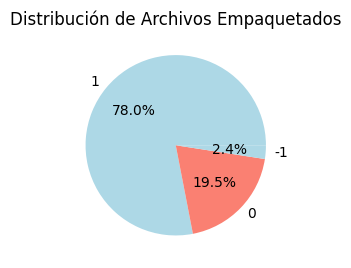

In [32]:
plt.subplot(1, 2, 1)
df['is_packed'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'salmon'])
plt.title('Distribución de Archivos Empaquetados')
plt.ylabel('')

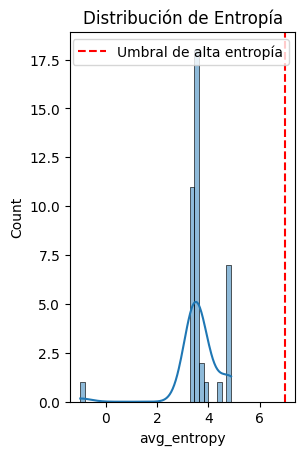

In [33]:
plt.subplot(1, 2, 2)
sns.histplot(df['avg_entropy'].dropna(), kde=True)
plt.axvline(x=7.0, color='r', linestyle='--', label='Umbral de alta entropía')
plt.title('Distribución de Entropía')
plt.legend()

## Preprocesamiento

In [34]:
#Seleccionar solo características numéricas
numerical_features = ['file_size', 'is_packed', 'number_of_sections', 'imported_dlls_count', 
                    'imported_functions_count', 'days_since_compile', 'avg_entropy', 
                    'max_entropy', 'is_dll', 'is_exe', 'suspicious_dll_count']

In [35]:
#Manejar valores faltantes con la mediana
df_clean = df[numerical_features].copy()
df_clean = df_clean.fillna(df_clean.median())

In [36]:
print(f"Dataset limpio con {df_clean.shape[0]} filas y {df_clean.shape[1]} columnas.")
print("Columnas seleccionadas:", numerical_features)

Dataset limpio con 41 filas y 11 columnas.
Columnas seleccionadas: ['file_size', 'is_packed', 'number_of_sections', 'imported_dlls_count', 'imported_functions_count', 'days_since_compile', 'avg_entropy', 'max_entropy', 'is_dll', 'is_exe', 'suspicious_dll_count']


In [37]:
#Normalización/Estandarización
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_clean),
    columns=df_clean.columns
)

In [38]:
print("Dataset escalado (primeras 5 filas):")
print(df_scaled.head())

Dataset escalado (primeras 5 filas):
   file_size  is_packed  number_of_sections  imported_dlls_count  \
0  -0.463407  -3.636549           -6.138067            -3.676155   
1  -0.520254   0.505076            0.114374            -0.935749   
2  -0.516196   0.505076            0.114374            -0.387667   
3  -0.516196   0.505076            0.114374            -0.387667   
4  -0.516196   0.505076            0.114374            -0.387667   

   imported_functions_count  days_since_compile  avg_entropy  max_entropy  \
0                 -0.792446           -5.737559    -5.168126    -5.781572   
1                 -0.530163            0.204568    -0.301342     0.307737   
2                 -0.497378            1.052216    -0.159749     0.285196   
3                 -0.497378            1.052216    -0.160306     0.284127   
4                 -0.497378            0.468854    -0.158446     0.287697   

     is_dll    is_exe  suspicious_dll_count  
0 -2.967212 -4.192627             -3.072261  

## Reducción de dimensionalidad simple (PCA)

In [39]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

In [40]:
#Añadir información de empaquetamiento para colorear
df_pca['is_packed'] = df['is_packed'].values

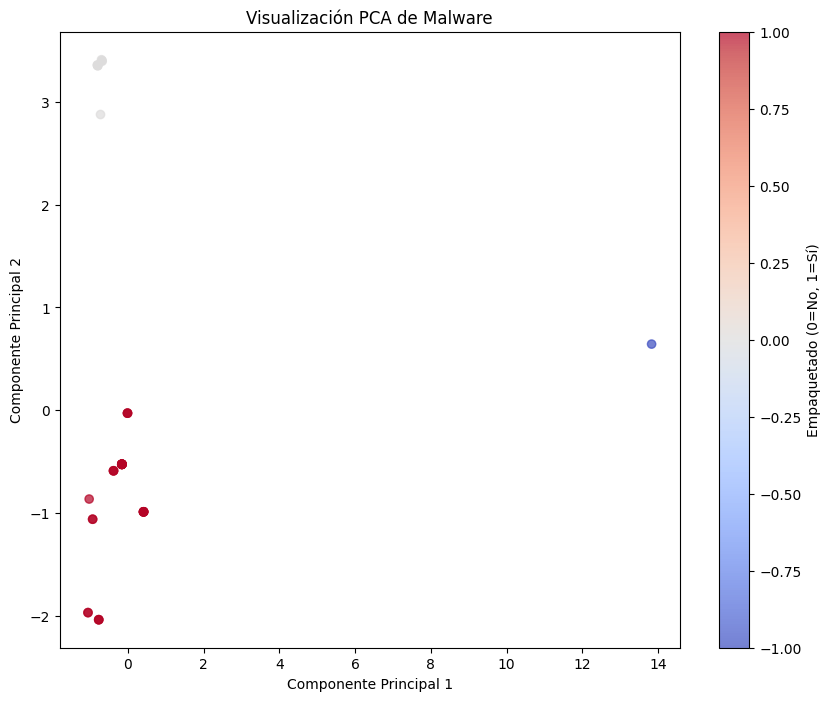

In [41]:
#Visualizar PCA
plt.figure(figsize=(10, 8))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['is_packed'], cmap='coolwarm', alpha=0.7)
plt.title('Visualización PCA de Malware')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Empaquetado (0=No, 1=Sí)')
plt.savefig('graphs/pca_malware.png')
plt.show()
plt.close()

## Clustering básico (K-means)

In [42]:
#Determinar número óptimo de clusters mediante el método del codo
inertias = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertias.append(kmeans.inertia_)

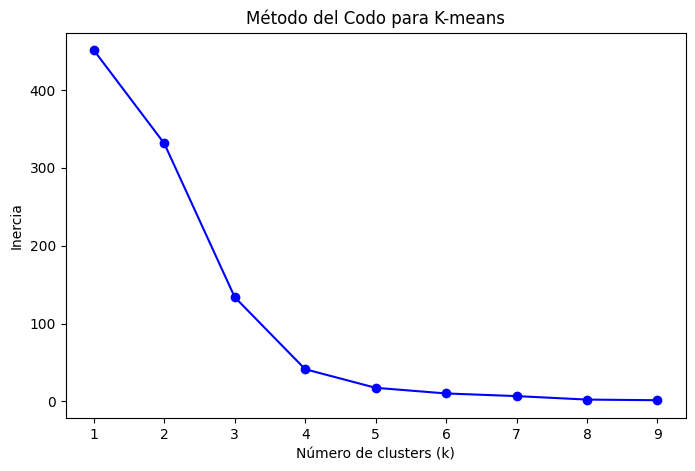

In [43]:
#Visualizar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para K-means')
plt.savefig('graphs/metodo_codo.png')
plt.show()
plt.close()

In [44]:
#Aplicar K-means con el número óptimo (según graphs/metodo_codo.png)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(df_scaled)

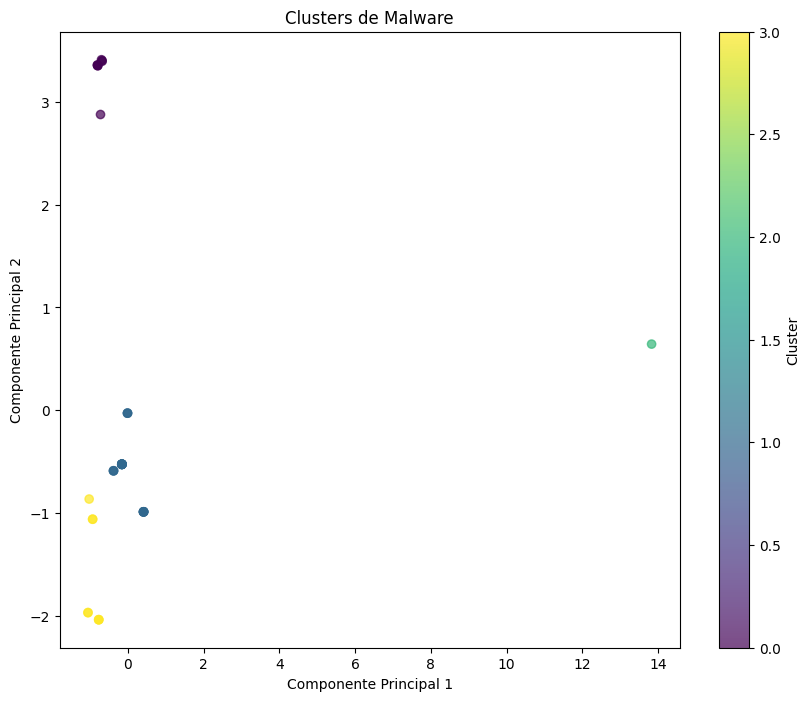

In [45]:
#Visualizar clusters
plt.figure(figsize=(10, 8))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df['cluster'], cmap='viridis', alpha=0.7)
plt.title('Clusters de Malware')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.savefig('graphs/clusters_malware.png')
plt.show()
plt.close()

## Análisis de clusters

In [46]:
cluster_analysis = df.groupby('cluster').agg({
    'is_packed': 'mean',
    'number_of_sections': 'mean',
    'imported_dlls_count': 'mean',
    'avg_entropy': 'mean',
    'file_size': 'mean',
    'file_name': 'count'  #Conteo de archivos por cluster
}).rename(columns={'file_name': 'count'})

In [47]:
print("\nAnálisis de clusters:")
print(cluster_analysis)


Análisis de clusters:
         is_packed  number_of_sections  imported_dlls_count  avg_entropy  \
cluster                                                                    
0              0.0               3.125                6.875     4.790047   
1              1.0               3.000                4.750     3.468889   
2             -1.0              -1.000               -1.000    -1.000000   
3              1.0               3.000                8.250     3.638434   

         file_size  count  
cluster                    
0          15552.0      8  
1           6592.0     24  
2          12292.0      1  
3         325760.0      8  


## Guardar datasets procesados

In [48]:
df_clean.to_csv('datasets/malware_dataset_clean.csv', index=False)
df['cluster'] = kmeans.labels_  # Añadir etiquetas de cluster
df.to_csv('datasets/malware_dataset_with_clusters.csv', index=False)

In [49]:
print("\nPreprocesamiento completado. Datasets guardados:")
print("* malware_dataset_clean.csv: Dataset limpio con características numéricas")
print("* malware_dataset_with_clusters.csv: Dataset original con etiquetas de cluster")


Preprocesamiento completado. Datasets guardados:
* malware_dataset_clean.csv: Dataset limpio con características numéricas
* malware_dataset_with_clusters.csv: Dataset original con etiquetas de cluster
